In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import shutil
import json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def download_data(folder_name, idaho_folder_path, json_file_name):
    blob_name = "https://lilablobssc.blob.core.windows.net/idaho-camera-traps/"
    
    if not os.path.isdir(idaho_folder_path + "/" + json_file_name):
        json_file_zip_name = json_file_name + ".zip"
        json_zip_to_download = blob_name + json_file_zip_name
        download_json_zip_command = "azcopy cp '%s' '%s'" % (json_zip_to_download, idaho_folder_path)
        os.system(download_json_zip_command)
        shutil.unpack_archive(json_file_zip_name)
        os.remove(idaho_folder_path + "/" + json_file_zip_name)
    else:
        print("Required json zip already downloaded")
    
    if not os.path.isdir(idaho_folder_path + "/" + folder_name):
        folder_to_download = blob_name + "public/" + folder_name
        download_folder_command = "azcopy cp '%s' '%s' --recursive" % (folder_to_download, idaho_folder_path)
        os.system(download_folder_command)
    else:
        print("Required folder already downloaded")

In [4]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)
    
def get_data_sets(folder_name, idaho_folder_path, json_file_name, categories_to_label_dict): 
    json_file = open(idaho_folder_path + "/" + json_file_name)
    coco_key = json.load(json_file)
    images = coco_key["images"]

    data, labels = [], []
    for index, image in enumerate(images):
        file_name = image["file_name"]
        file_path = idaho_folder_path + "/" + file_name
        
        if file_name.startswith(folder_name) and os.path.isfile(file_path):
            category_id = coco_key["annotations"][index]["category_id"]
            label = categories_to_label_dict[category_id]
            image_tensor = get_image_tensor(file_path)
            data.append(image_tensor)
            labels.append(label)
            print("Preparing image number: " + str(index))
    
    training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels)
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    
    json_file.close()
    
    shutil.rmtree(idaho_folder_path + "/" + folder_name)
    os.remove(idaho_folder_path + "/" + json_file_name)
    
    return training_data_set, testing_data_set

def get_loaders(training_data_set, testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader

In [5]:
def print_image(image_tensor, prediction):
    if(prediction == 1):
        prediction_string = "Wildlife Present"
    else:
        prediction_string = "No Wildlife Present"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()

def print_testing_analysis(all_labels, all_predictions, title):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        print("batch number: " + str(i))
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [6]:
def train_and_test(model, training_loader, testing_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(10):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion, True)
    print_testing_analysis(labels, predictions, "Overall")

In [7]:
def train_and_test_ResNet50(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet50")
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    resnet50.fc.out_features = num_classes
    train_and_test(resnet50, training_loader, testing_loader, device)

def train_and_test_ResNet152(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet152")
    resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
    resnet152.fc.out_features = num_classes
    train_and_test(resnet152, training_loader, testing_loader, device)

def train_and_test_ViT_L_16(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing Vision Transformer Large 16")
    vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
    vit_l_16.heads.out_features = num_classes
    train_and_test(vit_l_16, training_loader, testing_loader, device)

# Orchestration

In [8]:
num_classes = 2
batch_size = 10
json_file_name = "idaho-camera-traps.json"

#TODO: add loop here
folder_name = "loc_0000"

idaho_folder_path = "/Users/ChaseIson 1/Documents/Research/Code/oregon_wildlife_identification/model_benchmarking/Idaho"

# Mapping canines, big cats, bears, and ungulates to wildlife present and all other categories to no wildlife present
# This is mostly arbitrary and could be reworked, we just need to draw the line somewhere
categories_to_label_dict = {
    0:0, 1:0, 2:0, 3:1, 4:0, 5:1, 6:1, 7:0, 8:0, 9:1, 
    10:1, 11:0, 12:1, 13:1, 14:0, 15:0, 16:1, 17:0, 18:1, 19:0,
    20:1, 21:0, 22:1, 23:0, 24:1, 25:0, 26:0, 27:0, 28:0, 29:0,
    30:0, 31:0, 32:0, 33:0, 34:0, 35:0, 36:0, 37:0, 38:1, 39:1,
    40:1, 41:0, 42:0, 43:0, 44:0, 45:1, 46:0, 47:0, 48:1, 49:0,
    50:0, 51:0, 52:0, 53:0, 54:0, 55:0, 56:0, 57:0, 58:0, 59:0,
    60:0, 61:0,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [9]:
download_data(folder_name, idaho_folder_path, json_file_name)

INFO: Scanning...


ReadError: idaho-camera-traps.json.zip is not a zip file

In [ ]:
training_data_set, testing_data_set = get_data_sets(folder_name, idaho_folder_path, json_file_name, categories_to_label_dict)
training_loader, testing_loader = get_loaders(training_data_set, testing_data_set, batch_size)


Training and Testing ResNet50
epoch: 0
batch number: 0
predictions: tensor([272, 356, 276, 999, 306, 750, 744, 996, 756, 234])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 1
predictions: tensor([756, 875, 885, 118, 173, 766, 766, 181, 170, 905])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 2
predictions: tensor([111,  89, 801, 234, 318, 228, 756, 974,  96, 248])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 3
predictions: tensor([907, 218, 398, 619, 370, 750, 840, 722, 438,  82])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 4
predictions: tensor([514, 840, 345, 276, 395, 787, 194,  33, 691, 936])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 5
predictions: tensor([345, 786, 797, 787, 279, 542, 181, 712, 117, 796])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 6
predictions: tensor([469,   0, 763, 915, 311, 286, 133, 181,   0, 615])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
batch number: 7

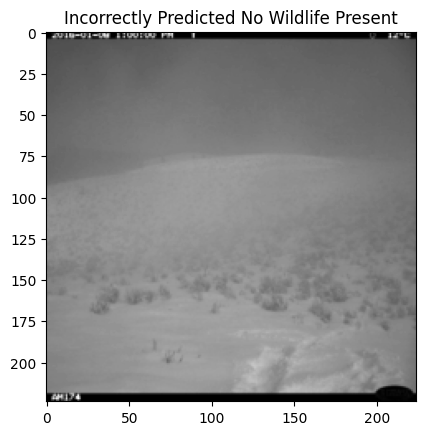

prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(978)
label: tensor(0)


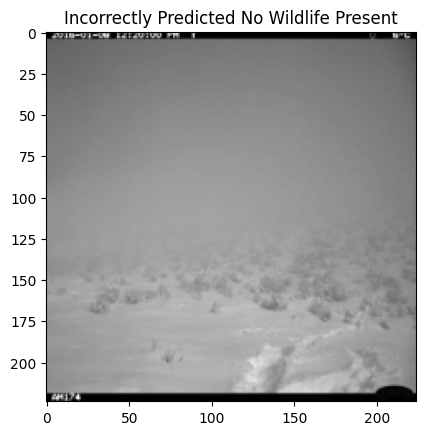

prediction: tensor(904)
label: tensor(0)


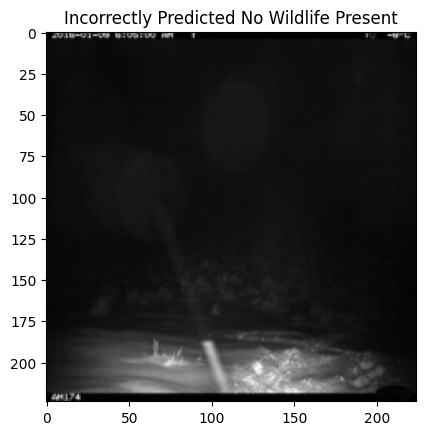

prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(0)
label: tensor(0)
prediction: tensor(525)
label: tensor(0)


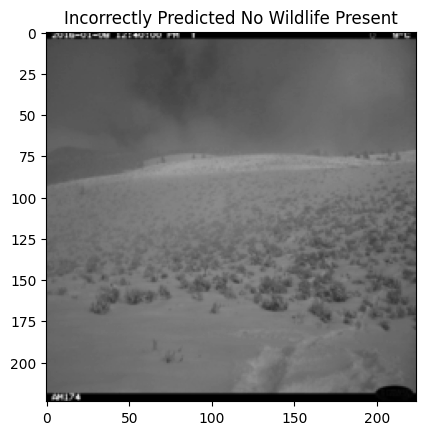

prediction: tensor(904)
label: tensor(0)


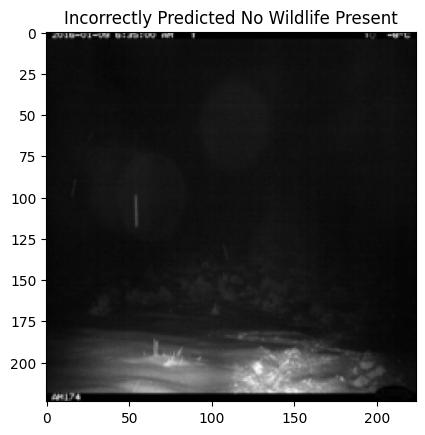

prediction: tensor(475)
label: tensor(0)


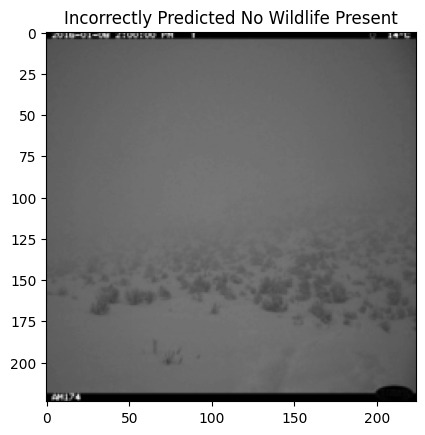

prediction: tensor(884)
label: tensor(0)


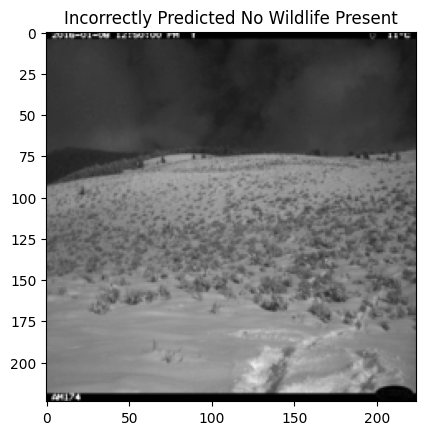

prediction: tensor(904)
label: tensor(0)


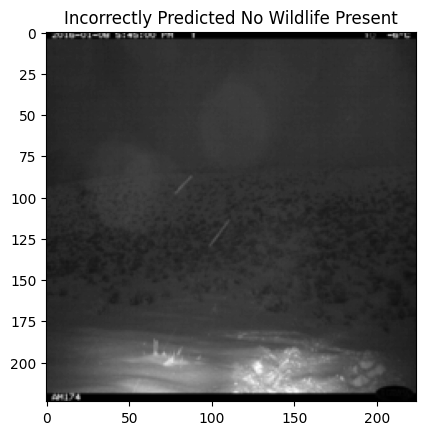

prediction: tensor(313)
label: tensor(0)


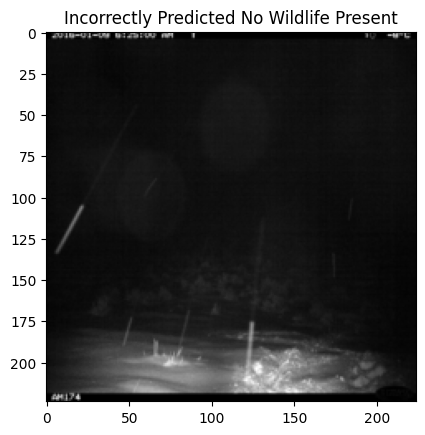

prediction: tensor(0)
label: tensor(0)
prediction: tensor(755)
label: tensor(0)


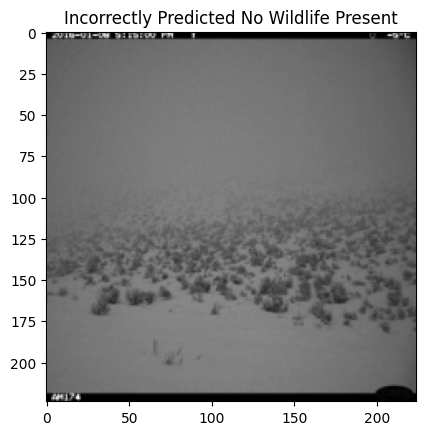

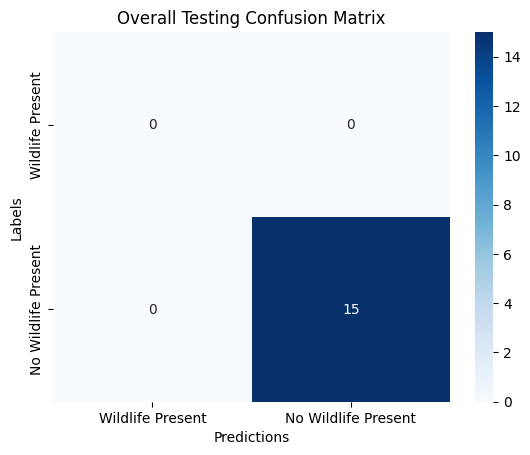

Overall Accuracy: 0.6


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [36]:
train_and_test_ResNet50(training_loader, testing_loader, device, num_classes)

In [ ]:
train_and_test_ResNet152(training_loader, testing_loader, device, num_classes)

In [ ]:
train_and_test_ViT_L_16(training_loader, testing_loader, device, num_classes)